## Feature Analysis FPL per position

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Global parameters

# Current gameweek 
gameweek = 16

## Collect available player data

In [3]:
# Initialize an empty list to store all individual, player gameweek data 
all_player_sep = []

# Loop through each gameweek
for i in range(1, gameweek + 1):  # Adjusting the range to start from 1 to gameweek
    # Read the CSV for the current gameweek
    x = pd.read_csv(rf'C:\Users\thoma\Code\Projects\Fantasy-Premier-League\Data\Players\Seperate_GW\GW_{i}.csv')
    
    # Append the current gameweek data to the list
    all_player_sep.append(x)

# Concatenate all dataframes in the list into a single dataframe
player_data = pd.concat(all_player_sep, axis=0, ignore_index=True)

# Drop unnamed column
player_data = player_data.drop(columns = ['Unnamed: 0'])

# Remove players who play less than 61 minutes in a game (i.e. they do not recieve their 2 points minimum for playoing this amount)
player_data = player_data[player_data['Minutes'] > 60].copy()

## Split by position

In [4]:
# Filter by Goalkeepers, Defenders, Midfielders, and Forwards
final_data_mids = player_data[player_data['Position'] == 'MID'].copy()
final_data_defs = player_data[player_data['Position'] == 'DEF'].copy()
final_data_gks = player_data[player_data['Position'] == 'GK'].copy()
final_data_fwds = player_data[player_data['Position'] == 'FWD'].copy()

# Combined dataset
data = [final_data_gks, final_data_defs, final_data_mids, final_data_fwds]

## Feature Selection per position

In [5]:
# Features for analysis 
features = ['Goals', 'Assists', 'Clean Sheets', 'Total Bonus Points', 'Saves', 'Penalties Saved','Penalties Missed', 'RC', 'YC']

# Regression model target  
t_col = ['GW Points']

## Run the model (w/ standardized coefficients)

Position: GK
Test MSE: 0.523
Coefficient (slope): [ 0.     0.333  1.79   0.692  0.619  0.721  0.     0.    -0.298]
Features: ['Goals', 'Assists', 'Clean Sheets', 'Total Bonus Points', 'Saves', 'Penalties Saved', 'Penalties Missed', 'RC', 'YC']
Intercept (β0): 3.2414647374975014


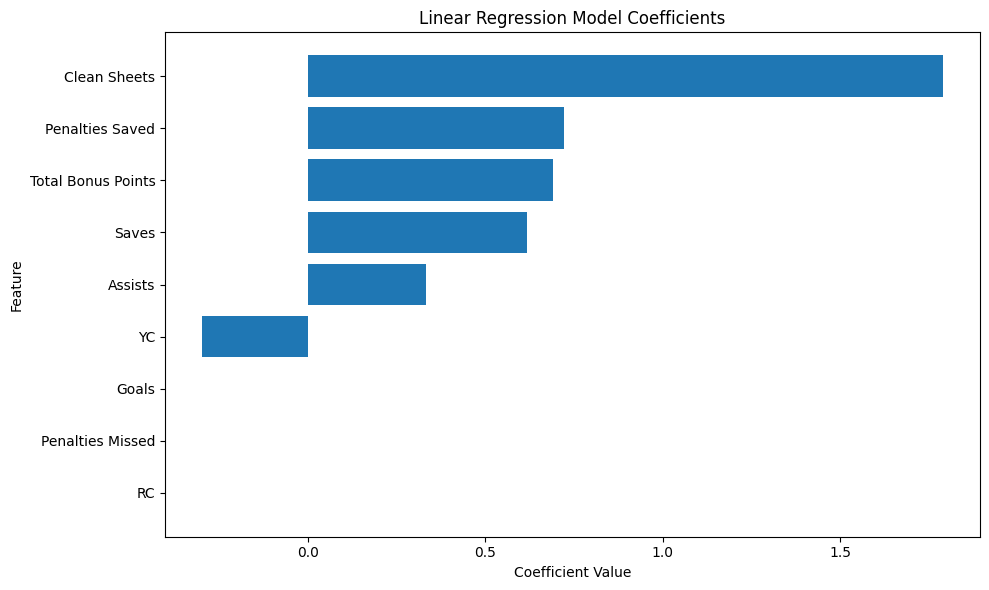

Position: DEF
Test MSE: 0.490
Coefficient (slope): [ 1.266  0.692  1.814  0.599 -0.     0.     0.    -0.275 -0.394]
Features: ['Goals', 'Assists', 'Clean Sheets', 'Total Bonus Points', 'Saves', 'Penalties Saved', 'Penalties Missed', 'RC', 'YC']
Intercept (β0): 2.699090394689337


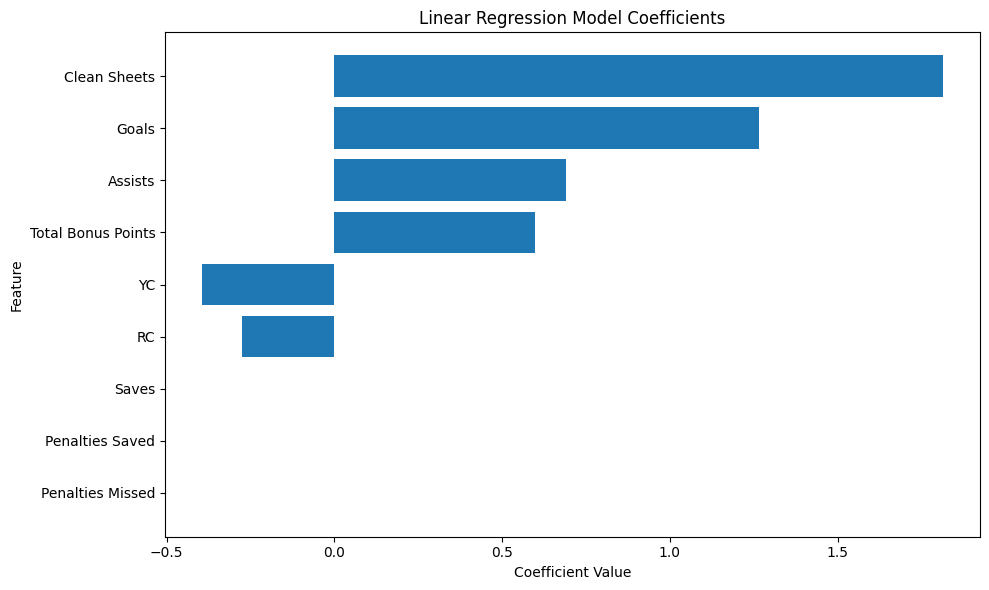

Position: MID
Test MSE: 0.000
Coefficient (slope): [ 2.067  1.204  0.436  0.807  0.    -0.    -0.092 -0.178 -0.398]
Features: ['Goals', 'Assists', 'Clean Sheets', 'Total Bonus Points', 'Saves', 'Penalties Saved', 'Penalties Missed', 'RC', 'YC']
Intercept (β0): 3.5580393955861944


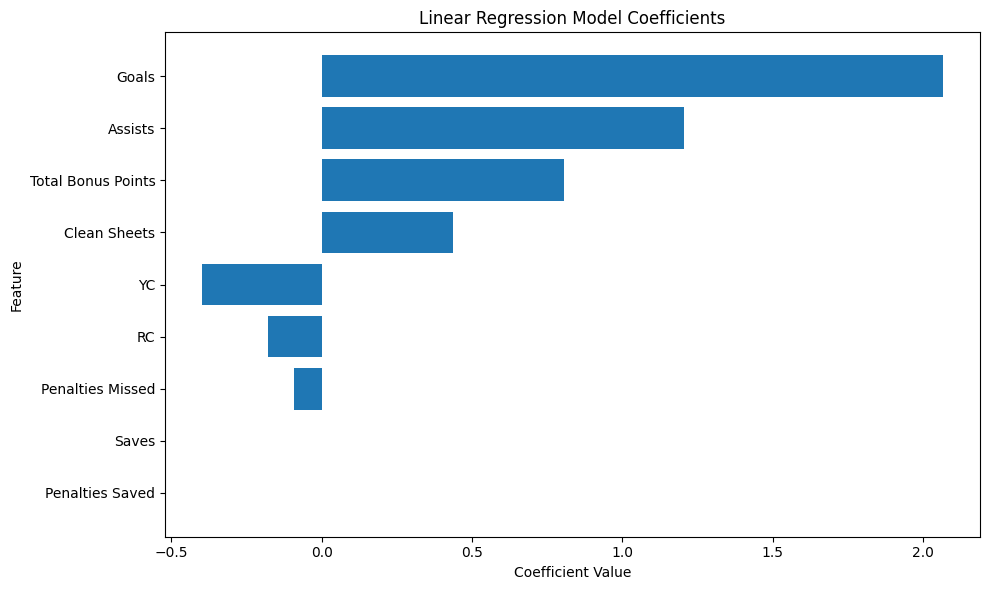

Position: FWD
Test MSE: 0.000
Coefficient (slope): [ 2.332  1.224  0.     1.132  0.     0.    -0.19   0.    -0.333]
Features: ['Goals', 'Assists', 'Clean Sheets', 'Total Bonus Points', 'Saves', 'Penalties Saved', 'Penalties Missed', 'RC', 'YC']
Intercept (β0): 4.5407854984894245


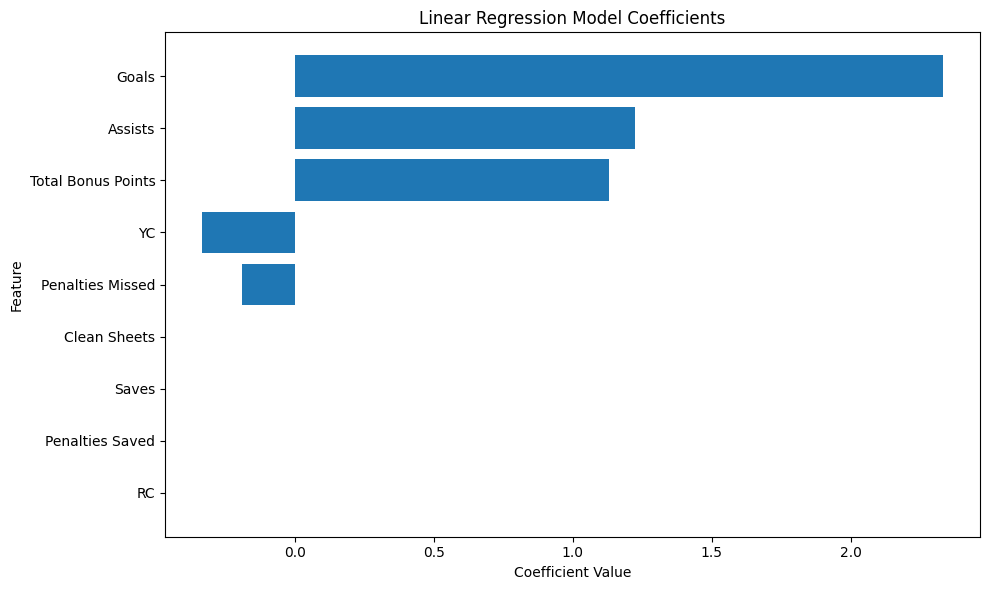

In [6]:
for idx, position in enumerate(data):
    # Prepare the feature matrix (2D) and target vector (1D)
    X = position[features].values  # Extract feature matrix as NumPy array
    y = position[t_col].values.flatten()  # Extract target as 1D array
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initialize the linear regression model
    linear_model = LinearRegression()

    # Fit the model
    linear_model.fit(X_train, y_train)

    # Make predictions
    y_pred = linear_model.predict(X_test).round(0)

    # Evaluate the model
    test_mse = mean_squared_error(y_test, y_pred)
    print(f"Position: {['GK', 'DEF', 'MID', 'FWD'][idx]}")
    print(f"Test MSE: {test_mse:.3f}")

    # Print coefficients and intercept
    coefficients = linear_model.coef_.round(3)
    intercept = linear_model.intercept_
    print(f"Coefficient (slope): {coefficients}")
    print(f"Features: {features}")
    print(f"Intercept (β0): {intercept}")

    # Create a DataFrame for visualization
    coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
    })

    # Sort the DataFrame by the absolute value of coefficients for better visualization
    coefficients_df['Abs_Coefficient'] = coefficients_df['Coefficient'].abs()
    coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

    # Plot the coefficients
    plt.figure(figsize=(10, 6))
    plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], align='center')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Linear Regression Model Coefficients')
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.tight_layout()
    plt.show()

## Impact of standardization

- **Before standardization**: Goals might have a coefficient that reflects its absolute scale (e.g., contributing more to total points due to larger numerical values, 6 vs. 4 for clean sheets).
- **After standardization**: The coefficients represent the impact of a **one standard deviation change** in each predictor on the target variable (total points).

Standardization removes the influence of different units or scales. After standardization, the relative strength of the coefficients purely reflects the predictors' influence on the target variable per unit of standard deviation. For example, the standardized coefficient for clean sheets being much higher contributer than assists for defenders suggests it is more impactful on total points when considered on a comparable scale.

## Conclusion: key predictors to simplify the model

- Goalkeepers: CLEAN SHEETS
- Defenders: CLEAN SHEETS + goals 
- Midfielders: GOALS + assists 
- Forwards: GOALS